# Subreddit Comparison

I modelled the scraped subreddit data by doing a train test split, transforming using a Tfidf Vectorizer, converting this data to a Sparse Dataframe,  and then modelling this data using two different models: RandomForestClassifier (using a GridSearchCV) and a Multinomial Naive Bayes model

In [220]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB         # Naive Bayes
from sklearn import metrics
%matplotlib inline

## Reading in The Scraped Data

In [221]:
#read combined.csv into 'combined_subreddits' dataframe
combined_subreddits = pd.read_csv('./datasets/combined.csv')

In [222]:
# look at first 5 values of the dataframe
combined_subreddits.head()

,text,cheese
0,"FAQ: What is cheese, anyway?",1
1,Cheese plate I made yesterday for a friend and I,1
2,A selection of goat cheeses this evening with ...,1
3,delice de poitou,1
4,Cheese “dessert” plate: whipped chèvre in chou...,1


In [223]:
# look at last 5 values of the dataframe
combined_subreddits.tail()

,text,cheese
7266,If smoking marijuana causes short-term memory ...,0
7267,Those damn edibles,0
7268,Allergies,0
7269,Join the official /r/weed Discord server!,0
7270,Anyone travel with weed in their checked lugga...,0


### Regex Cleaning

I used regex to remove the words `cheese, cheeses, weed, weeds`. I also removed *any* mention of a subreddit, as well as all URLs.

In [224]:
# replacing \ stuff with spaces
combined_subreddits['text'] = combined_subreddits.text.map(lambda x: re.sub('\s[\/]?r\/[^s]+', ' ', x)) 
# see https://regex101.com/ (copy and paste '\s[\/]?r\/[^s]+', ' ' in the website search)

# replacing http/s stuff
combined_subreddits['text'] = combined_subreddits.text.map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))


#removes cheese or weed and plusal[s]
combined_subreddits['text'] = combined_subreddits.text.map(lambda x: re.sub('(cheese|weed)[s]?', ' ', x, flags=re.I)) 


In [225]:
# look at first 5 values of the dataframe
combined_subreddits.head()

,text,cheese
0,"FAQ: What is , anyway?",1
1,plate I made yesterday for a friend and I,1
2,A selection of goat this evening with some y...,1
3,delice de poitou,1
4,“dessert” plate: whipped chèvre in choux pas...,1


In [226]:
# look at last 5 values of the dataframe
combined_subreddits.tail()

,text,cheese
7266,If smoking marijuana causes short-term memory ...,0
7267,Those damn edibles,0
7268,Allergies,0
7269,Join the official scord server!,0
7270,Anyone travel with in their checked luggage?...,0


## Additional Cleaning (EDA)

In [227]:
# drop the duplicate values so there are only unique posts in the dataframe
combined_subreddits.drop_duplicates(inplace=True)

In [228]:
# observe how many entries there are after dropping duplicates
len(combined_subreddits)

3806

In [229]:
# check how many/if there exist any null values in this dataframe
combined_subreddits.isnull().sum()

text      0
cheese    0
dtype: int64

In [230]:
# check datatypes in this dataframe.  text should be a string (object) and cheese should be an int (int64)
combined_subreddits.dtypes

text      object
cheese    object
dtype: object

In [231]:
# when looking at the unique entries in what is supposed to be a binary 'dummy' column for whether the post is from
# the cheese subreddit or not, I saw that there was at least one entry with the string "cheese" incident
combined_subreddits['cheese'].unique()

array(['1', '0', 'cheese'], dtype=object)

In [232]:
# looking through the dataframe this incident occurred thankfully only once (at index 3638)
combined_subreddits[combined_subreddits['cheese'] == 'cheese']

,text,cheese
3638,text,cheese


In [233]:
# double checking the index 3638 to see that it was indeed the culprit
combined_subreddits['cheese'][3638]

'cheese'

In [234]:
# dropping the string from the dummy column
combined_subreddits.drop(combined_subreddits.index[3638], inplace=True)

In [270]:
# rechecking to make sure only 1s and 0s are in the dummy column.  Mission accomplished!
combined_subreddits['cheese'].unique()

array(['1', '0'], dtype=object)

## Creating Train-Test-Split, Vectorizing The Dataframe, and Formatting The Data

In [236]:
# Set the X and y values to be used in the models
X = combined_subreddits.drop('cheese', axis=1) #text
y = combined_subreddits['cheese'] #cheese (as 1 or 0, where 1 means IS in cheese subreddit and 0 means is NOT)

In [237]:
# stratify: ratio makes sure test maintains same ratio of data as train data has ie 50% cheese in both
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=24)


In [238]:
#Instantiate a TFIDF vectorizer, removing english stopwords
tfidf = TfidfVectorizer(stop_words='english', max_df=.95, min_df=5)

In [239]:
# Create a corpus out of the list of titles. Fit and transform the vecotrizer on the corpus
train_raw = tfidf.fit_transform(X_train['text'])

In [240]:
# print the corpus to see what it looks like
print(train_raw)

  (0, 737)	0.3013923393718982
  (0, 306)	0.3013923393718982
  (0, 803)	0.5414142680670371
  (0, 166)	0.4186734467135183
  (0, 539)	0.14172132246100871
  (0, 967)	0.25095027464189434
  (0, 713)	0.15365184657299438
  (0, 503)	0.1506961696859491
  (0, 92)	0.15365184657299438
  (0, 857)	0.1506961696859491
  (0, 588)	0.15365184657299438
  (0, 337)	0.15365184657299438
  (0, 578)	0.1506961696859491
  (0, 974)	0.08552190567966458
  (0, 479)	0.1506961696859491
  (0, 860)	0.13535356701675927
  (0, 746)	0.15706392513019857
  (0, 1002)	0.12460699872760116
  (0, 221)	0.12547513732094717
  (1, 386)	0.3896281580724027
  (1, 145)	0.6560468485435275
  (1, 498)	0.19550594765660229
  (1, 135)	0.2628504735110899
  (1, 103)	0.3391390390938786
  (1, 679)	0.301590846597878
  :	:
  (2656, 135)	0.20339517511214397
  (2656, 491)	0.13467857831716126
  (2656, 829)	0.1515541025715397
  (2656, 521)	0.13364139954271753
  (2656, 385)	0.2271082143621177
  (2656, 729)	0.24085666102223352
  (2656, 761)	0.225227541270214

In [241]:
# Convert the vectorized data into a dataframe
# use SparseDataFrame for space considerations
train_df = pd.SparseDataFrame(train_raw, columns=tfidf.get_feature_names()) 
# SparseDataFrame tells you where values are instead of giving every single cell.  good for text data

#check first 5 values for train_df
train_df.head()

,10,100,11,12,15,16,17,18,20,200,...,x200b,yard,yeah,year,years,yellow,yes,yesterday,young,yum
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
# used fillna to replace nulls with 0 (as all NaNs are just a result of the sparse representation)
train_df.fillna(0, inplace=True)

In [243]:
# check how many/if there exist any null values in this dataframe
train_df.isnull().sum().sum()

0

In [244]:
# check first 5 values of X_test dataframe
X_test.head()

,text
788,Whole milk ricotta on chocolate crispbreads sp...
2448,Haha legit.
3203,That kush
2977,Childhood friends
439,Where do I start? I really want to get into ...


In [245]:
# I replicated the process of transforming the X_train and for the X_test
test_raw = tfidf.transform(X_test['text'])
# Convert the vectorized data into a dataframe
# use SparseDataFrame for space considerations
test_df = pd.SparseDataFrame(test_raw, columns=tfidf.get_feature_names())
# use fillna to replace nulls with 0 (as all NaNs are just a result of the sparse representation)
test_df.fillna(0, inplace=True)
# check the first 5 values of the new dataframe
test_df.head()

,10,100,11,12,15,16,17,18,20,200,...,x200b,yard,yeah,year,years,yellow,yes,yesterday,young,yum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fitting Two Different Model Using `cheese` As The Target

### RandomForestClassifier

I instantiated a GridSearchCV for RandomForestClassifier, then fit and scored it on the train data.  Setting 100 estimators, I searched over `min_samples_split` and `max_depth`.

In [271]:
# setting the parameters for the Random Forrest Classifier to be searched through by the Grid Search
params = {'min_samples_split': [8, 10, 12],
         'max_depth': [50, 75, 100]}

In [247]:
# instantiate a Random Forrest Classifier as rf
rf = RandomForestClassifier(n_estimators=100)

In [248]:
# instantiate a Grid Search passing through the Random Forrest Classifier and parameters defined above
gs = GridSearchCV(rf, param_grid=params, return_train_score=True, cv=5)
# fit the model to the train data
gs.fit(train_df, y_train)
# score the model on the train data
gs.score(train_df, y_train)

0.8895981975215922

**Score on the test data**

In [249]:
# Score on the test data
gs.score(test_df, y_test)

0.8239929947460596

In [272]:
# what were the best parameters?
gs.best_params_

{'max_depth': 100, 'min_samples_split': 10}

In [276]:
# Creating a list of the 20 words that have the "greatest importance" on determining whether or not the subreddit came
# from the cheese subreddit or the weed subreddit
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, train_df.columns, columns=['importance'])

feat_importance.sort_values(by='importance', ascending=False).head(20)

,importance
board,0.047878
cheddar,0.033228
smoke,0.032877
store,0.028435
high,0.027198
brie,0.021361
smoking,0.019184
plate,0.018130
blue,0.017040
german,0.016665


In [275]:
# Here is a list of the 20 words that have the "least importance" on determining whether or not the subreddit came
# from the cheese subreddit or the weed subreddit
feat_importance.sort_values(by='importance', ascending=False).tail(20)

,importance
imagine,0.0
sesh,0.0
fat,0.0
idk,0.0
comes,0.0
playing,0.0
eventually,0.0
threw,0.0
cartridges,0.0
selling,0.0


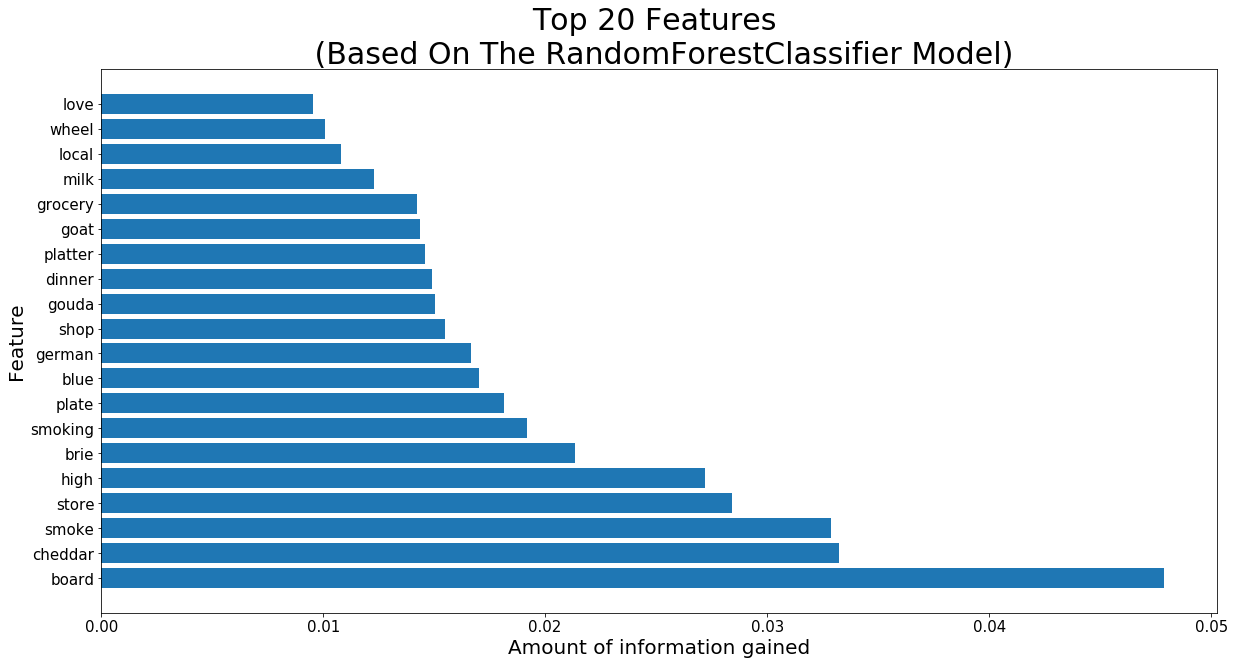

In [295]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title('Top 20 Features \n (Based On The RandomForestClassifier Model)', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Feature', fontsize=20);

## Naive Bayes Model

In [288]:
# use the train and test values obtained and transformed with the tfidf vectorizer from before into
# SparseDataFrames as train_df and test_df
 

# Use Multinomial Naive Bayes to predict whether or not post is from the cheese subreddit
nb = MultinomialNB()
# fit to the tfidf-transformed training data
nb.fit(train_df, y_train)

# use the model to predict which subreddit the word came from
y_pred_class = nb.predict(test_df)

# Calculate accuracy.
# return train score
print(nb.score(train_df, y_train))
# return the test score
print(nb.score(test_df, y_test))

0.8862185505069471
0.8432574430823118


In [301]:
# get the top 20 highest predictive features as estimated by this instance of the Multinomial Naive Bayes Model
# these are determined by the coef_ parameter of the MNB model.  Note that the coef_ parameter of the MNB returns
# the log of the estimated probability of a feature given the positive class, so I took it to the exponent of the
# natural number by calling np.exp on it.  Additionally, it had to be transposed with .T to fit the train_df columns
feat_importance2 = pd.DataFrame(np.exp(nb.coef_).T, train_df.columns, columns=['importance'])
feat_importance2.sort_values(by='importance', ascending=False).head(20)

,importance
store,0.010399
german,0.010002
grocery,0.009687
board,0.009613
cheddar,0.006853
love,0.005567
blue,0.005485
brie,0.005309
like,0.005112
plate,0.005033


In [302]:
feat_importance2.sort_values(by='importance', ascending=False).tail(20)

,importance
user,0.000299
scared,0.000299
ain,0.000299
ur,0.000299
pass,0.000299
rips,0.000299
multiple,0.000299
medical,0.000299
cuz,0.000299
paranoid,0.000299


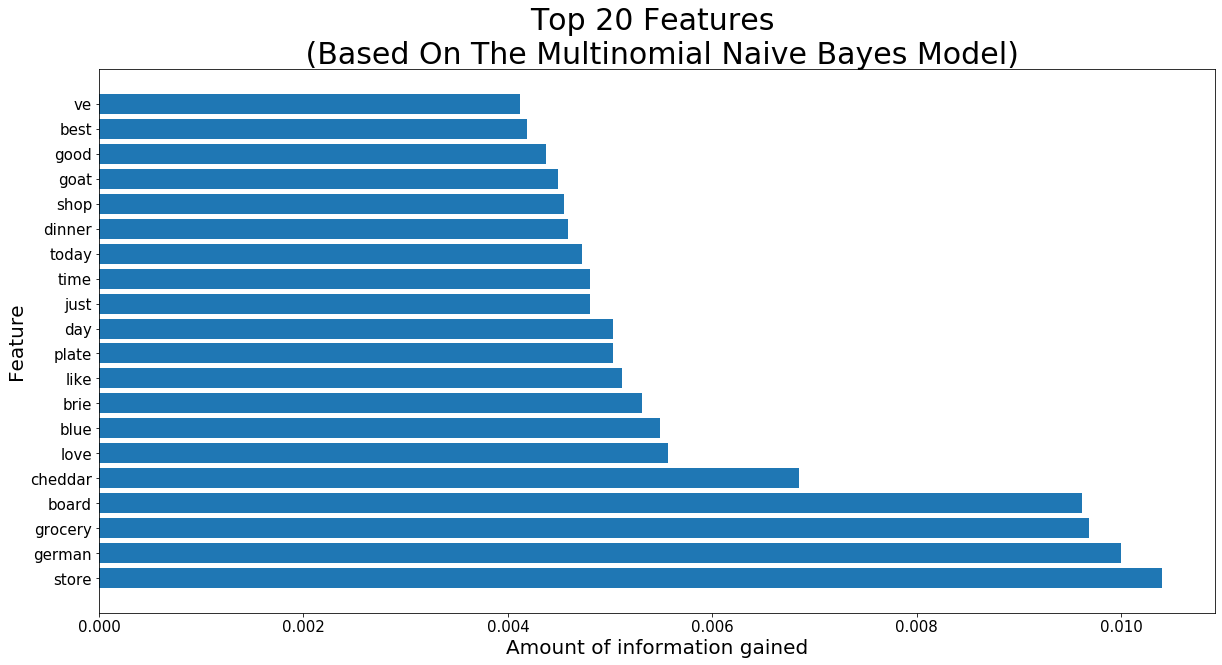

In [305]:
plt.figure(figsize=(20,10))
temp = feat_importance2.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title('Top 20 Features \n (Based On The Multinomial Naive Bayes Model)', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Feature', fontsize=20);

## Conclusion and Results

Using the Random Forrest model over 100 n_estimators, through a gridsearch testing over parameters of 8, 10 and 12 for 'min_samples_split' and 50, 75, and 100 for 'max_depth', the training score was about 89% and the testing score was about 82%.  Using the Multinomial Naive Bayes model with the built in parameters, the training score was 89% and the testing score was 84%.  Both models worked fairly well, and almost equally accurately, with the Random Forrest Model being just a hair overfit and weaker than the Multinomial Naive Bayes model.  I think that, had I munged the data a little more thoroughly, and perhaps gotten more scraping done, I could have improved the models.